# Predict NO3-N over the stream network

### Rough Outline

Import dataframes for months<br>
Import dataframes for all the variables<br>
Import the best parameters<br>
Create the merged dataframe for the training model<br>
Create a dataframe for predictions<br>
Fit the model using the training data:  Creating model again instead of importing existing model because of limitations of python pickle<br>
Make predictions on the unseen data<br>
Plot the predicted data on a map


In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import geopandas as gpd
#from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib.gridspec import GridSpec
from matplotlib import cm
#from matplotlib.ticker import FuncFormatter, FixedLocator

In [2]:
# Setting the display options for dataframes
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 1000

In [3]:
#encode months as cyclical features

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [4]:
# calculate pearson correlation coefficient

def pearson_corr_coeff(X,y):
    X_bar = np.mean(X)
    y_bar = np.mean(y)
    numr = np.sum((X-X_bar)*(y-y_bar))
    denmr = np.sqrt(np.sum(np.square(X-X_bar)*np.sum(np.square(y-y_bar))))
    r = numr/denmr
    return r

In [5]:
# function to load environmental variables to the notebook. These datasets were processed and saved in other notebooks. 

def import_features(feature):
    clim_var = None
    with open(feature, 'rb') as file:
        # Deserialize and retrieve the variable from the file
        clim_var = pickle.load(file)
    return clim_var

In [6]:
# Add the data for all 12 months in a dictionary with the month name as key and 

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
dataframes = {}

for i,month in enumerate(months):
    with open(f"final_df_{month}_new", 'rb') as file:
        final_df_month_new = pickle.load(file)
        # add month nuber to dataframe at a specific column index
        final_df_month_new['month'] = i+1 
        final_df_month_new.insert(2,'month',final_df_month_new.pop('month')) # insertion index, name to insert, value to insert. pop deletes the column but also returns its value
        final_df_month_new = encode(final_df_month_new,'month',12)
    dataframes[month] = final_df_month_new

In [7]:
with open('study_opt_merged_best_params_copy', 'rb') as file:
    study_opt_merged_best_params = pickle.load(file)

with open("lambda_boxcox", 'rb') as file:
    lambda_boxcox = pickle.load(file)

# Load the shapefile
shapefile_path = r"J:\study_project\geoBoundaries-DEU-ADM1-all\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

In [8]:
study_opt_merged_best_params

{'n_estimators': 230,
 'max_depth': 41,
 'min_samples_split': 3,
 'min_samples_leaf': 1}

In [9]:
dataframes['jul']

NO3-N [mg/l]  NO3-N [mg/l] BC  month  \
0        4.821333         2.188384      7   
1        2.471000         1.028438      7   
2        3.766667         1.714114      7   
3        2.734500         1.145806      7   
4        4.819500         2.106403      7   
5        6.328000         2.726419      7   
6        6.629333         2.821920      7   
7        2.881500         1.301034      7   
8        2.591333         1.139601      7   
9        1.039571         0.037623      7   
10       0.682400        -0.357717      7   
11       3.237500         1.476225      7   
12       1.001667        -0.005439      7   
13       1.779750         0.580340      7   
14       1.777667         0.640398      7   
15       4.407000         2.020808      7   
16       3.415111         1.575748      7   
17       1.508250         0.412380      7   
18       1.536667         0.466496      7   
19       0.596333        -0.474446      7   
20       7.420333         3.054307      7   
21       3.486857         1.607538      7   
22       4.616544         2.083653      7   
23       3.537000         1.506469      7   
24       3.860447         1.772242      7   
25       1.555353         0.468526      7   
26       0.565000        -0.515141      7   
27       2.697138         1.194713      7   
28       3.584034         1.641522      7   
29       0.520000        -0.575478      7   
30       3.785500         1.737444      7   
31       5.198000         2.329296      7   
32       4.520000         2.063109      7   
33       8.211333         3.301091      7   
34       3.150400         1.249247      7   
35       0.542000        -0.543303      7   
36       2.561333         1.136420      7   
37       2.702744         1.214877      7   
38       0.416059        -0.742259      7   
39       1.178270         0.151467      7   
40       4.444667         2.031921      7   
41       1.232316         0.205560      7   
42       0.979167        -0.024301      7   
43       4.670667         2.103293      7   
44       1.864077         0.699466      7   
45       1.152500         0.144944      7   
46       0.729268        -0.306586      7   
47       3.073500         1.388246      7   
48       2.655500         1.187692      7   
49       0.972000        -0.215174      7   
50       4.124500         1.866338      7   
51       1.998429         0.786795      7   
52       2.636667         1.178886      7   
53       0.881333        -0.162071      7   
54       4.407000         1.988155      7   
55       0.490000        -0.621116      7   
56       1.182667         0.153915      7   
57       1.172900        -0.006375      7   
58       4.407000         2.006335      7   
59       3.073667         1.225940      7   
60       4.520000         2.066382      7   
61       2.410667         1.053562      7   
62       3.621947         1.679853      7   
63       4.407000         2.020808      7   
64       3.768649         1.720178      7   
65       5.819500         2.552450      7   
66       4.143333         1.892300      7   
67       1.993474         0.787719      7   
68       3.164000         1.451925      7   
69       0.966000        -0.035741      7   
70       5.001478         2.246021      7   
71       0.949700        -0.059476      7   
72       1.785500         0.650753      7   
73       0.935400        -0.067334      7   
74       3.069000         1.371356      7   
75       3.465333         1.600683      7   
76       1.017000        -0.005816      7   
77       4.859000         2.198904      7   
78       2.787333         1.266206      7   
79       1.898333         0.721668      7   
80       2.360324         1.007700      7   
81       2.684878         1.192162      7   
82       2.147000         0.839526      7   
83       2.132000         0.837188      7   
84       4.143333         1.867947      7   
85       2.034000         0.591239      7   
86       0.538000        -0.556538      7   
87       0.753333        -0.280632      7   


In [10]:
# remove the month number from tmin, tmax and prec_sum columns to concat the dataframes later
new_dataframes = {}
i=1
for month in dataframes.keys():
    new_dataframes[month] = dataframes[month].rename(columns={f"tmin_avg_{i}": "tmin_avg", f"tmax_avg_{i}": "tmax_avg", f"prec_sum_{i}": "prec_sum" })
    i=i+1

In [11]:
# merge all monthly dataframes in one dataframe

merged_dfs = pd.concat(new_dataframes.values()).reset_index(drop = True)

In [12]:
merged_dfs

NO3-N [mg/l]  NO3-N [mg/l] BC  month                       station_name  \
0         6.162333         2.671989      1   Strbr. in Höhe v. Stein, obh. KA   
1         4.294000         1.977289      1  Str.br.von Neundorf nach Bächlein   
2         8.701000         3.437690      1   Strbr. Höhe Äußerer Bürgergraben   
3         3.446500         1.589518      1                   Strbr. Oberteich   
4         3.465333         1.607559      1     Straßenbr zum KW Oberelchingen   
...            ...              ...    ...                                ...   
5892      6.893000         2.908309     12                 800m uh. Wenigrötz   
5893      0.892500        -0.187924     12   800m oh nordwestl Ammeraltwasser   
5894      4.350500         1.999735     12    200m u.h. Bahnl. Markt Schwaben   
5895      4.972000         2.247549     12             700m oh Mündung in Ach   
5896      0.990212        -0.017195     12                 Augsburg Hochablaß   

     station_number                          water_body        lat        lon  \
0             13516                           Ölschnitz  50.062500  11.704167   
1             15123                              Föritz  50.254167  11.212500   
2             20496                          Schwabbach  49.987500   9.979167   
3             23397                        Seibertsbach  49.937500  12.212500   
4             42442                               Leibi  48.437500  10.104167   
...             ...                                 ...        ...        ...   
5892         105645                          Rötzerbach  49.329167  12.387500   
5893         113898                       Waizackerbach  47.862500  11.129167   
5894         130316                 Forstinninger Sempt  48.212500  11.887500   
5895         136340  Dinkelshausener Arrondierungskanal  48.645833  11.170833   
5896           3044                                Lech  48.345833  10.937500   

      slope_avg  elev_avg  lc_avg_01  lc_avg_02  lc_avg_03  lc_avg_04  \
0         216.0     584.0       15.0        0.0        7.0       12.0   
1         240.0     381.0       22.0        0.0       10.0       46.0   
2         118.0     303.0        0.0        0.0        5.0        2.0   
3         190.0     589.0       23.0        0.0       11.0       37.0   
4         224.0     745.0        6.0        0.0       13.0       15.0   
...         ...       ...        ...        ...        ...        ...   
5892      148.0     476.0        1.0        0.0        6.0        4.0   
5893      433.0     875.0       20.0        0.0       18.0       24.0   
5894       49.0     544.0       19.0        0.0        8.0       25.0   
5895       96.0     417.0        3.0        0.0        6.0        9.0   
5896      752.0    1208.0       20.0        0.0       10.0       18.0   

      lc_avg_05  lc_avg_06  lc_avg_07  lc_avg_08  lc_avg_09  lc_avg_10  \
0           0.0        1.0       53.0        0.0        1.0        0.0   
1           0.0        0.0       21.0        0.0        0.0        0.0   
2           0.0        0.0       86.0        0.0        0.0        0.0   
3           0.0        1.0       22.0        0.0        1.0        0.0   
4           0.0        4.0       51.0        0.0        2.0        0.0   
...         ...        ...        ...        ...        ...        ...   
5892        0.0        3.0       70.0        0.0        1.0        0.0   
5893        0.0        5.0       26.0        0.0        2.0        0.0   
5894        0.0        0.0       38.0        0.0        3.0        0.0   
5895        0.0        4.0       68.0        0.0        0.0        0.0   
5896        2.0       12.0       28.0        0.0        1.0        0.0   

      lc_avg_11  lc_avg_12  hydro_avg_01  hydro_avg_02  hydro_avg_03  \
0          11.0        0.0          73.0          81.0          31.0   
1           1.0        0.0          81.0          87.0          32.0   
2           7.0        0.0          89.0          90.0          32.0   
3     

In [13]:
# Scale the data and divide in training and testing sets

scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_dfs.iloc[:,8:])
scaled_df = pd.DataFrame(scaled_features, index=merged_dfs.index, columns=merged_dfs.columns[8:])
scaled_df = scaled_df.astype('float32')  # Explicitly cast to float32 if needed because the data type might not match

# Replace the original data with the scaled data
merged_dfs_scaled = merged_dfs.copy()
merged_dfs_scaled.iloc[:, 8:] = scaled_df

X = merged_dfs_scaled.iloc[:,8:]
y = merged_dfs_scaled.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_indices = X_train.index
test_indices = X_test.index

In [14]:
merged_dfs_scaled

NO3-N [mg/l]  NO3-N [mg/l] BC  month                       station_name  \
0         6.162333         2.671989      1   Strbr. in Höhe v. Stein, obh. KA   
1         4.294000         1.977289      1  Str.br.von Neundorf nach Bächlein   
2         8.701000         3.437690      1   Strbr. Höhe Äußerer Bürgergraben   
3         3.446500         1.589518      1                   Strbr. Oberteich   
4         3.465333         1.607559      1     Straßenbr zum KW Oberelchingen   
...            ...              ...    ...                                ...   
5892      6.893000         2.908309     12                 800m uh. Wenigrötz   
5893      0.892500        -0.187924     12   800m oh nordwestl Ammeraltwasser   
5894      4.350500         1.999735     12    200m u.h. Bahnl. Markt Schwaben   
5895      4.972000         2.247549     12             700m oh Mündung in Ach   
5896      0.990212        -0.017195     12                 Augsburg Hochablaß   

     station_number                          water_body        lat        lon  \
0             13516                           Ölschnitz  50.062500  11.704167   
1             15123                              Föritz  50.254167  11.212500   
2             20496                          Schwabbach  49.987500   9.979167   
3             23397                        Seibertsbach  49.937500  12.212500   
4             42442                               Leibi  48.437500  10.104167   
...             ...                                 ...        ...        ...   
5892         105645                          Rötzerbach  49.329167  12.387500   
5893         113898                       Waizackerbach  47.862500  11.129167   
5894         130316                 Forstinninger Sempt  48.212500  11.887500   
5895         136340  Dinkelshausener Arrondierungskanal  48.645833  11.170833   
5896           3044                                Lech  48.345833  10.937500   

      slope_avg  elev_avg  lc_avg_01  lc_avg_02  lc_avg_03  lc_avg_04  \
0     -0.116886 -0.054875   0.363857        0.0  -0.444847  -0.513696   
1     -0.029112 -0.813065   0.963898        0.0   0.067776   2.817858   
2     -0.475297 -1.104389  -0.921947        0.0  -0.786596  -1.493565   
3     -0.211974 -0.036200   1.049619        0.0   0.238651   1.935977   
4     -0.087628  0.546448  -0.407625        0.0   0.580400  -0.219735   
...         ...       ...        ...        ...        ...        ...   
5892  -0.365579 -0.458247  -0.836227        0.0  -0.615722  -1.297591   
5893   0.676738  1.031988   0.792458        0.0   1.434772   0.662147   
5894  -0.727647 -0.204272   0.706738        0.0  -0.273973   0.760134   
5895  -0.555756 -0.678608  -0.664786        0.0  -0.615722  -0.807657   
5896   1.843403  2.275719   0.792458        0.0   0.067776   0.074225   

      lc_avg_05  lc_avg_06  lc_avg_07  lc_avg_08  lc_avg_09  lc_avg_10  \
0     -0.286547  -0.628431   0.263604  -0.086984  -0.248520  -0.185967   
1     -0.286547  -0.918926  -1.300545  -0.086984  -0.474332  -0.185967   
2     -0.286547  -0.918926   1.876632  -0.086984  -0.474332  -0.185967   
3     -0.286547  -0.628431  -1.251666  -0.086984  -0.248520  -0.185967   
4     -0.286547   0.243057   0.165844  -0.086984  -0.022708  -0.185967   
...         ...        ...        ...        ...        ...        ...   
5892  -0.286547  -0.047439   1.094558  -0.086984  -0.248520  -0.185967   
5893  -0.286547   0.533553  -1.056147  -0.086984  -0.022708  -0.185967   
5894  -0.286547  -0.918926  -0.469591  -0.086984   0.203105  -0.185967   
5895  -0.286547   0.243057   0.996799  -0.086984  -0.474332  -0.185967   
5896   3.285903   2.567024  -0.958388  -0.086984  -0.248520  -0.185967   

      lc_avg_11  lc_avg_12  hydro_avg_01  hydro_avg_02  hydro_avg_03  \
0      0.580014  -0.349340     -0.742093     -1.680899     -0.667452   
1     -1.861343  -0.349340      0.362709     -0.146929      0.436605   
2     -0.396529  -0.349340      1.467511      0.620057      0.436605   
3     

In [15]:
# Implement the import_features function to load environmental variables

df_filtered_slope = import_features("df_filtered_slope")
df_filtered_elev_avg = import_features("df_filtered_elev_avg")
df_filtered_landcover = import_features("df_filtered_landcover")
df_filtered_hydroclim = import_features("df_filtered_hydroclim")
df_filtered_soil_avg = import_features("df_filtered_soil_avg")
df_filtered_tmin_avg = import_features("df_filtered_tmin_avg")
df_filtered_tmax_avg = import_features("df_filtered_tmax_avg")
df_filtered_prec_us_sum = import_features("df_filtered_prec_us_sum")

In [16]:
df_filtered_slope

variable   index        lat        lon       3
0           1902  47.295833  10.229167  1423.0
1           2487  47.304167  10.237500  1436.0
2           2488  47.304167  10.245833  1463.0
3           3073  47.312500  10.254167  1493.0
4           3074  47.312500  10.262500  1532.0
...          ...        ...        ...     ...
16445     228480  50.529167  10.112500   350.0
16446     228481  50.529167  10.120833   370.0
16447     228482  50.529167  10.129167   373.0
16448     228484  50.529167  10.145833   366.0
16449     229067  50.537500  10.137500   372.0

[16450 rows x 4 columns]

In [17]:
df_filtered_elev_avg

variable   index        lat        lon       3
0           1902  47.295833  10.229167  1798.0
1           2487  47.304167  10.237500  1781.0
2           2488  47.304167  10.245833  1752.0
3           3073  47.312500  10.254167  1741.0
4           3074  47.312500  10.262500  1761.0
...          ...        ...        ...     ...
16445     228480  50.529167  10.112500   716.0
16446     228481  50.529167  10.120833   699.0
16447     228482  50.529167  10.129167   676.0
16448     228484  50.529167  10.145833   640.0
16449     229067  50.537500  10.137500   656.0

[16450 rows x 4 columns]

In [18]:
df_filtered_landcover

variable   index        lat        lon     0    1     2     3    4     5  \
0           1902  47.295833  10.229167  29.0  0.0   6.0   7.0  3.0  25.0   
1           2487  47.304167  10.237500  28.0  0.0   6.0   6.0  3.0  25.0   
2           2488  47.304167  10.245833  28.0  0.0   8.0   8.0  4.0  23.0   
3           3073  47.312500  10.254167  27.0  0.0   7.0   9.0  4.0  24.0   
4           3074  47.312500  10.262500  25.0  0.0   7.0  10.0  5.0  23.0   
...          ...        ...        ...   ...  ...   ...   ...  ...   ...   
16445     228480  50.529167  10.112500   0.0  0.0   7.0  10.0  0.0  10.0   
16446     228481  50.529167  10.120833   0.0  0.0   7.0   9.0  0.0  10.0   
16447     228482  50.529167  10.129167   0.0  0.0   6.0   8.0  0.0   9.0   
16448     228484  50.529167  10.145833   0.0  0.0  10.0  17.0  0.0   5.0   
16449     229067  50.537500  10.137500   0.0  0.0  11.0  18.0  0.0   6.0   

variable     6    7    8    9    10   11  
0         20.0  0.0  0.0  0.0   8.0  2.0  
1         21.0  0.0  0.0  0.0   8.0  2.0  
2         20.0  0.0  0.0  0.0   7.0  2.0  
3         21.0  0.0  0.0  0.0   7.0  2.0  
4         18.0  0.0  0.0  0.0  10.0  2.0  
...        ...  ...  ...  ...   ...  ...  
16445     66.0  0.0  0.0  0.0   7.0  0.0  
16446     66.0  0.0  0.0  0.0   9.0  0.0  
16447     66.0  0.0  0.0  0.0  11.0  0.0  
16448     55.0  0.0  0.0  0.0  12.0  0.0  
16449     55.0  0.0  0.0  0.0  10.0  0.0  

[16450 rows x 15 columns]

In [19]:
df_filtered_tmin_avg

variable   index        lat        lon     0     1     2     3     4     5  \
0           1902  47.295833  10.229167 -79.0 -72.0 -40.0  -3.0  36.0  69.0   
1           2487  47.304167  10.237500 -81.0 -74.0 -43.0  -7.0  33.0  66.0   
2           2488  47.304167  10.245833 -80.0 -73.0 -42.0  -6.0  33.0  66.0   
3           3073  47.312500  10.254167 -80.0 -74.0 -43.0  -7.0  33.0  65.0   
4           3074  47.312500  10.262500 -80.0 -73.0 -42.0  -6.0  34.0  66.0   
...          ...        ...        ...   ...   ...   ...   ...   ...   ...   
16445     228480  50.529167  10.112500 -48.0 -43.0 -18.0  10.0  51.0  84.0   
16446     228481  50.529167  10.120833 -47.0 -43.0 -18.0  10.0  52.0  85.0   
16447     228482  50.529167  10.129167 -47.0 -42.0 -17.0  10.0  52.0  85.0   
16448     228484  50.529167  10.145833 -46.0 -41.0 -16.0  11.0  53.0  86.0   
16449     229067  50.537500  10.137500 -47.0 -42.0 -17.0  10.0  52.0  85.0   

variable      6      7     8     9    10    11  
0          88.0   85.0  62.0  21.0 -24.0 -62.0  
1          85.0   82.0  60.0  19.0 -26.0 -64.0  
2          86.0   83.0  60.0  20.0 -25.0 -64.0  
3          85.0   82.0  59.0  19.0 -26.0 -64.0  
4          86.0   83.0  60.0  20.0 -25.0 -64.0  
...         ...    ...   ...   ...   ...   ...  
16445     102.0   99.0  67.0  32.0   0.0 -27.0  
16446     102.0  100.0  68.0  32.0   0.0 -27.0  
16447     102.0  100.0  68.0  32.0   0.0 -26.0  
16448     103.0  101.0  69.0  33.0   1.0 -25.0  
16449     103.0  100.0  68.0  32.0   0.0 -26.0  

[16450 rows x 15 columns]

In [20]:
### MERGE ALL THE STATIC FEATURE DATA REQUIRED TO MAKE PREDICTIONS IN A SINGLE DATAFRAME

# Merge the dataframe one by one using the coorindates as the common data. Drop some columns to improve formatting. 
# Suffixes option is specified while merging because all environmental variables dataframes have similar naming convention for columns
df1 = df_filtered_slope.drop(columns='index')
df2 = pd.merge(df1, df_filtered_elev_avg, on=['lon', 'lat'], how='left')
df2 = df2.drop(columns='index')
df3 = pd.merge(df2, df_filtered_landcover, on=['lon', 'lat'], how='left')
df3 = df3.drop(columns='index')
df4 = pd.merge(df3, df_filtered_hydroclim, on=['lon', 'lat'], how='left',suffixes=(None, 'hydroclim'))
df4 = df4.drop(columns='index')
df5 = pd.merge(df4, df_filtered_soil_avg, on=['lon', 'lat'], how='left',suffixes=(None, 'soil_avg'))
df5 = df5.drop(columns='index')


In [21]:
df5

variable        lat        lon     3_x     3_y     0    1     2     3    4  \
0         47.295833  10.229167  1423.0  1798.0  29.0  0.0   6.0   7.0  3.0   
1         47.304167  10.237500  1436.0  1781.0  28.0  0.0   6.0   6.0  3.0   
2         47.304167  10.245833  1463.0  1752.0  28.0  0.0   8.0   8.0  4.0   
3         47.312500  10.254167  1493.0  1741.0  27.0  0.0   7.0   9.0  4.0   
4         47.312500  10.262500  1532.0  1761.0  25.0  0.0   7.0  10.0  5.0   
...             ...        ...     ...     ...   ...  ...   ...   ...  ...   
16445     50.529167  10.112500   350.0   716.0   0.0  0.0   7.0  10.0  0.0   
16446     50.529167  10.120833   370.0   699.0   0.0  0.0   7.0   9.0  0.0   
16447     50.529167  10.129167   373.0   676.0   0.0  0.0   6.0   8.0  0.0   
16448     50.529167  10.145833   366.0   640.0   0.0  0.0  10.0  17.0  0.0   
16449     50.537500  10.137500   372.0   656.0   0.0  0.0  11.0  18.0  0.0   

variable     5     6    7    8    9    10   11  0hydroclim  1hydroclim  \
0         25.0  20.0  0.0  0.0  0.0   8.0  2.0        51.0        89.0   
1         25.0  21.0  0.0  0.0  0.0   8.0  2.0        47.0        87.0   
2         23.0  20.0  0.0  0.0  0.0   7.0  2.0        48.0        87.0   
3         24.0  21.0  0.0  0.0  0.0   7.0  2.0        47.0        87.0   
4         23.0  18.0  0.0  0.0  0.0  10.0  2.0        48.0        87.0   
...        ...   ...  ...  ...  ...   ...  ...         ...         ...   
16445     10.0  66.0  0.0  0.0  0.0   7.0  0.0        71.0        91.0   
16446     10.0  66.0  0.0  0.0  0.0   9.0  0.0        71.0        91.0   
16447      9.0  66.0  0.0  0.0  0.0  11.0  0.0        71.0        91.0   
16448      5.0  55.0  0.0  0.0  0.0  12.0  0.0        72.0        91.0   
16449      6.0  55.0  0.0  0.0  0.0  10.0  0.0        72.0        91.0   

variable  2hydroclim  3hydroclim  4hydroclim  5hydroclim  6hydroclim  \
0               33.0      6325.0       189.0       -79.0       268.0   
1               32.0      6276.0       184.0       -81.0       265.0   
2               33.0      6255.0       184.0       -80.0       264.0   
3               33.0      6261.0       183.0       -80.0       263.0   
4               33.0      6253.0       184.0       -80.0       264.0   
...              ...         ...         ...         ...         ...   
16445           34.0      6353.0       217.0       -48.0       265.0   
16446           34.0      6353.0       217.0       -47.0       264.0   
16447           34.0      6342.0       217.0       -47.0       264.0   
16448           34.0      6348.0       218.0       -46.0       264.0   
16449           34.0      6353.0       217.0       -47.0       264.0   

variable  7hydroclim  8hydroclim  9hydroclim  10hydroclim  11hydroclim  \
0              130.0       -21.0       130.0        -31.0      33503.0   
1              126.0       -24.0       126.0        -34.0      36881.0   
2              126.0       -23.0       126.0        -33.0      42307.0   
3              125.0       -24.0       125.0        -34.0      45645.0   
4              126.0       -23.0       126.0        -33.0      59137.0   
...              ...         ...         ...          ...          ...   
16445          153.0        28.0       153.0        -10.0      27592.0   
16446          153.0        28.0       153.0         -9.0      29871.0   
16447          153.0        28.0       153.0         -9.0      32851.0   
16448          154.0        29.0       154.0         -8.0      59276.0   
16449          154.0        28.0       154.0         -9.0      54888.0   

variable      12      13    14       15       16       17       18  0soil_avg  \
0         4184.0  1950.0  27.0  11917.0   6160.0  11917.0   6160.0       98.0   
1         4614.0  2140.0  27.0  13139.0   6759.0  13139.0   6759.0       97.0   
2         5308.0  2439.0  28.0  15118.0   7700.0  15118.0   7700.0      100.0   
3         5734.0  2625.0  28.0  16331.0   8287.0  16331.0   8287.0       98.0   
4         7399.

In [22]:
# Rename the columns

new_names = ['slope_avg',
    'elev_avg',
    'lc_avg_01',
    'lc_avg_02',
    'lc_avg_03',
    'lc_avg_04',
    'lc_avg_05',
    'lc_avg_06',
    'lc_avg_07',
    'lc_avg_08',
    'lc_avg_09',
    'lc_avg_10',
    'lc_avg_11',
    'lc_avg_12',
    'hydro_avg_01',
    'hydro_avg_02',
    'hydro_avg_03',
    'hydro_avg_04',
    'hydro_avg_05',
    'hydro_avg_06',
    'hydro_avg_07',
    'hydro_avg_08',
    'hydro_avg_09',
    'hydro_avg_10',
    'hydro_avg_11',
    'hydro_avg_12',
    'hydro_avg_13',
    'hydro_avg_14',
    'hydro_avg_15',
    'hydro_avg_16',
    'hydro_avg_17',
    'hydro_avg_18',
    'hydro_avg_19',
    'soil_avg_01',
    'soil_avg_02',
    'soil_avg_03',
    'soil_avg_04',
    'soil_avg_05',
    'soil_avg_06',
    'soil_avg_07',
    'soil_avg_08',
    'soil_avg_09',
    'soil_avg_10']
# Create a dictionary mapping old column names to new ones
rename_dict = {df5.columns[i]: new_names[i - 2] for i in range(2, 45)}

# Rename the columns using the names defined above
df5.rename(columns=rename_dict, inplace=True)

In [23]:
df5

variable        lat        lon  slope_avg  elev_avg  lc_avg_01  lc_avg_02  \
0         47.295833  10.229167     1423.0    1798.0       29.0        0.0   
1         47.304167  10.237500     1436.0    1781.0       28.0        0.0   
2         47.304167  10.245833     1463.0    1752.0       28.0        0.0   
3         47.312500  10.254167     1493.0    1741.0       27.0        0.0   
4         47.312500  10.262500     1532.0    1761.0       25.0        0.0   
...             ...        ...        ...       ...        ...        ...   
16445     50.529167  10.112500      350.0     716.0        0.0        0.0   
16446     50.529167  10.120833      370.0     699.0        0.0        0.0   
16447     50.529167  10.129167      373.0     676.0        0.0        0.0   
16448     50.529167  10.145833      366.0     640.0        0.0        0.0   
16449     50.537500  10.137500      372.0     656.0        0.0        0.0   

variable  lc_avg_03  lc_avg_04  lc_avg_05  lc_avg_06  lc_avg_07  lc_avg_08  \
0               6.0        7.0        3.0       25.0       20.0        0.0   
1               6.0        6.0        3.0       25.0       21.0        0.0   
2               8.0        8.0        4.0       23.0       20.0        0.0   
3               7.0        9.0        4.0       24.0       21.0        0.0   
4               7.0       10.0        5.0       23.0       18.0        0.0   
...             ...        ...        ...        ...        ...        ...   
16445           7.0       10.0        0.0       10.0       66.0        0.0   
16446           7.0        9.0        0.0       10.0       66.0        0.0   
16447           6.0        8.0        0.0        9.0       66.0        0.0   
16448          10.0       17.0        0.0        5.0       55.0        0.0   
16449          11.0       18.0        0.0        6.0       55.0        0.0   

variable  lc_avg_09  lc_avg_10  lc_avg_11  lc_avg_12  hydro_avg_01  \
0               0.0        0.0        8.0        2.0          51.0   
1               0.0        0.0        8.0        2.0          47.0   
2               0.0        0.0        7.0        2.0          48.0   
3               0.0        0.0        7.0        2.0          47.0   
4               0.0        0.0       10.0        2.0          48.0   
...             ...        ...        ...        ...           ...   
16445           0.0        0.0        7.0        0.0          71.0   
16446           0.0        0.0        9.0        0.0          71.0   
16447           0.0        0.0       11.0        0.0          71.0   
16448           0.0        0.0       12.0        0.0          72.0   
16449           0.0        0.0       10.0        0.0          72.0   

variable  hydro_avg_02  hydro_avg_03  hydro_avg_04  hydro_avg_05  \
0                 89.0          33.0        6325.0         189.0   
1                 87.0          32.0        6276.0         184.0   
2                 87.0          33.0        6255.0         184.0   
3                 87.0          33.0        6261.0         183.0   
4                 87.0          33.0        6253.0         184.0   
...                ...           ...           ...           ...   
16445             91.0          34.0        6353.0         217.0   
16446             91.0          34.0        6353.0         217.0   
16447             91.0          34.0        6342.0         217.0   
16448             91.0          34.0        6348.0         218.0   
16449             91.0          34.0        6353.0         217.0   

variable  hydro_avg_06  hydro_avg_07  hydro_avg_08  hydro_avg_09  \
0                -79.0         268.0         130.0         -21.0   
1                -81.0         265.0         126.0         -24.0   
2                -80.0         264.0         126.0         -23.0   
3                -80.0         263.0         125.0         -24.0   
4                -80.0         264.0         126.0         -23.0   
...                ...           ...           ...           ...   
1644

In [24]:
# Add the time dependent features to df5 and save a new dataframe for every month 

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
pred_dfs = {}

for i,month in enumerate(months):
    df_month = df5.copy()
    df_month[f"tmin_avg_{i+1}"] = df_filtered_tmin_avg.iloc[:,i+3]
    df_month[f"tmax_avg_{i+1}"] = df_filtered_tmax_avg.iloc[:,i+3]
    df_month[f"prec_sum_{i+1}"] = df_filtered_prec_us_sum.iloc[:,i+3]
    df_month.insert(2, "month", i+1)
    df_month = encode(df_month, "month", 12)
    pred_dfs[month] = df_month
    

In [25]:
pred_dfs["aug"]

variable        lat        lon  month  slope_avg  elev_avg  lc_avg_01  \
0         47.295833  10.229167      8     1423.0    1798.0       29.0   
1         47.304167  10.237500      8     1436.0    1781.0       28.0   
2         47.304167  10.245833      8     1463.0    1752.0       28.0   
3         47.312500  10.254167      8     1493.0    1741.0       27.0   
4         47.312500  10.262500      8     1532.0    1761.0       25.0   
...             ...        ...    ...        ...       ...        ...   
16445     50.529167  10.112500      8      350.0     716.0        0.0   
16446     50.529167  10.120833      8      370.0     699.0        0.0   
16447     50.529167  10.129167      8      373.0     676.0        0.0   
16448     50.529167  10.145833      8      366.0     640.0        0.0   
16449     50.537500  10.137500      8      372.0     656.0        0.0   

variable  lc_avg_02  lc_avg_03  lc_avg_04  lc_avg_05  lc_avg_06  lc_avg_07  \
0               0.0        6.0        7.0        3.0       25.0       20.0   
1               0.0        6.0        6.0        3.0       25.0       21.0   
2               0.0        8.0        8.0        4.0       23.0       20.0   
3               0.0        7.0        9.0        4.0       24.0       21.0   
4               0.0        7.0       10.0        5.0       23.0       18.0   
...             ...        ...        ...        ...        ...        ...   
16445           0.0        7.0       10.0        0.0       10.0       66.0   
16446           0.0        7.0        9.0        0.0       10.0       66.0   
16447           0.0        6.0        8.0        0.0        9.0       66.0   
16448           0.0       10.0       17.0        0.0        5.0       55.0   
16449           0.0       11.0       18.0        0.0        6.0       55.0   

variable  lc_avg_08  lc_avg_09  lc_avg_10  lc_avg_11  lc_avg_12  hydro_avg_01  \
0               0.0        0.0        0.0        8.0        2.0          51.0   
1               0.0        0.0        0.0        8.0        2.0          47.0   
2               0.0        0.0        0.0        7.0        2.0          48.0   
3               0.0        0.0        0.0        7.0        2.0          47.0   
4               0.0        0.0        0.0       10.0        2.0          48.0   
...             ...        ...        ...        ...        ...           ...   
16445           0.0        0.0        0.0        7.0        0.0          71.0   
16446           0.0        0.0        0.0        9.0        0.0          71.0   
16447           0.0        0.0        0.0       11.0        0.0          71.0   
16448           0.0        0.0        0.0       12.0        0.0          72.0   
16449           0.0        0.0        0.0       10.0        0.0          72.0   

variable  hydro_avg_02  hydro_avg_03  hydro_avg_04  hydro_avg_05  \
0                 89.0          33.0        6325.0         189.0   
1                 87.0          32.0        6276.0         184.0   
2                 87.0          33.0        6255.0         184.0   
3                 87.0          33.0        6261.0         183.0   
4                 87.0          33.0        6253.0         184.0   
...                ...           ...           ...           ...   
16445             91.0          34.0        6353.0         217.0   
16446             91.0          34.0        6353.0         217.0   
16447             91.0          34.0        6342.0         217.0   
16448             91.0          34.0        6348.0         218.0   
16449             91.0          34.0        6353.0         217.0   

variable  hydro_avg_06  hydro_avg_07  hydro_avg_08  hydro_avg_09  \
0                -79.0         268.0         130.0         -21.0   
1                -81.0         265.0         126.0         -24.0   
2                -80.0         264.0         126.0         -23.0   
3                -80.0         263.0         125.0         -24.0   
4                -80.0         264.0         126.0      

In [26]:
# remove the month number from tmin, tmax and prec_sum columns to concat the dataframes later

new_dataframes_pred = {}
i=1
for month in pred_dfs.keys():
    new_dataframes_pred[month] = pred_dfs[month].rename(columns={f"tmin_avg_{i}": "tmin_avg", f"tmax_avg_{i}": "tmax_avg", f"prec_sum_{i}": "prec_sum" })
    i=i+1

In [27]:
new_dataframes_pred

{'jan': variable        lat        lon  month  slope_avg  elev_avg  lc_avg_01  \
 0         47.295833  10.229167      1     1423.0    1798.0       29.0   
 1         47.304167  10.237500      1     1436.0    1781.0       28.0   
 2         47.304167  10.245833      1     1463.0    1752.0       28.0   
 3         47.312500  10.254167      1     1493.0    1741.0       27.0   
 4         47.312500  10.262500      1     1532.0    1761.0       25.0   
 ...             ...        ...    ...        ...       ...        ...   
 16445     50.529167  10.112500      1      350.0     716.0        0.0   
 16446     50.529167  10.120833      1      370.0     699.0        0.0   
 16447     50.529167  10.129167      1      373.0     676.0        0.0   
 16448     50.529167  10.145833      1      366.0     640.0        0.0   
 16449     50.537500  10.137500      1      372.0     656.0        0.0   
 
 variable  lc_avg_02  lc_avg_03  lc_avg_04  lc_avg_05  lc_avg_06  lc_avg_07  \
 0               0.0    

In [28]:
# Merge the monthly dataframes to create the dataset to make predictions
pred_dfs_merged = pd.concat(new_dataframes_pred.values()).reset_index(drop = True)

In [29]:
pred_dfs_merged

variable        lat        lon  month  slope_avg  elev_avg  lc_avg_01  \
0         47.295833  10.229167      1     1423.0    1798.0       29.0   
1         47.304167  10.237500      1     1436.0    1781.0       28.0   
2         47.304167  10.245833      1     1463.0    1752.0       28.0   
3         47.312500  10.254167      1     1493.0    1741.0       27.0   
4         47.312500  10.262500      1     1532.0    1761.0       25.0   
...             ...        ...    ...        ...       ...        ...   
197395    50.529167  10.112500     12      350.0     716.0        0.0   
197396    50.529167  10.120833     12      370.0     699.0        0.0   
197397    50.529167  10.129167     12      373.0     676.0        0.0   
197398    50.529167  10.145833     12      366.0     640.0        0.0   
197399    50.537500  10.137500     12      372.0     656.0        0.0   

variable  lc_avg_02  lc_avg_03  lc_avg_04  lc_avg_05  lc_avg_06  lc_avg_07  \
0               0.0        6.0        7.0        3.0       25.0       20.0   
1               0.0        6.0        6.0        3.0       25.0       21.0   
2               0.0        8.0        8.0        4.0       23.0       20.0   
3               0.0        7.0        9.0        4.0       24.0       21.0   
4               0.0        7.0       10.0        5.0       23.0       18.0   
...             ...        ...        ...        ...        ...        ...   
197395          0.0        7.0       10.0        0.0       10.0       66.0   
197396          0.0        7.0        9.0        0.0       10.0       66.0   
197397          0.0        6.0        8.0        0.0        9.0       66.0   
197398          0.0       10.0       17.0        0.0        5.0       55.0   
197399          0.0       11.0       18.0        0.0        6.0       55.0   

variable  lc_avg_08  lc_avg_09  lc_avg_10  lc_avg_11  lc_avg_12  hydro_avg_01  \
0               0.0        0.0        0.0        8.0        2.0          51.0   
1               0.0        0.0        0.0        8.0        2.0          47.0   
2               0.0        0.0        0.0        7.0        2.0          48.0   
3               0.0        0.0        0.0        7.0        2.0          47.0   
4               0.0        0.0        0.0       10.0        2.0          48.0   
...             ...        ...        ...        ...        ...           ...   
197395          0.0        0.0        0.0        7.0        0.0          71.0   
197396          0.0        0.0        0.0        9.0        0.0          71.0   
197397          0.0        0.0        0.0       11.0        0.0          71.0   
197398          0.0        0.0        0.0       12.0        0.0          72.0   
197399          0.0        0.0        0.0       10.0        0.0          72.0   

variable  hydro_avg_02  hydro_avg_03  hydro_avg_04  hydro_avg_05  \
0                 89.0          33.0        6325.0         189.0   
1                 87.0          32.0        6276.0         184.0   
2                 87.0          33.0        6255.0         184.0   
3                 87.0          33.0        6261.0         183.0   
4                 87.0          33.0        6253.0         184.0   
...                ...           ...           ...           ...   
197395            91.0          34.0        6353.0         217.0   
197396            91.0          34.0        6353.0         217.0   
197397            91.0          34.0        6342.0         217.0   
197398            91.0          34.0        6348.0         218.0   
197399            91.0          34.0        6353.0         217.0   

variable  hydro_avg_06  hydro_avg_07  hydro_avg_08  hydro_avg_09  \
0                -79.0         268.0         130.0         -21.0   
1                -81.0         265.0         126.0         -24.0   
2                -80.0         264.0         126.0         -23.0   
3                -80.0         263.0         125.0         -24.0   
4                -80.0         264.0         126.0      

In [30]:
# Scale the data

scaled_features_pred = scaler.transform(pred_dfs_merged.iloc[:,3:])
scaled_df_pred = pd.DataFrame(scaled_features_pred, index=pred_dfs_merged.index, columns=pred_dfs_merged.columns[3:])
scaled_df_pred = scaled_df_pred.astype('float32')  # Explicitly cast to float32 if needed because the data type might not match

# Replace the original data with the scaled data
pred_dfs_merged_scaled = pred_dfs_merged.copy()
pred_dfs_merged_scaled.iloc[:, 3:] = scaled_df_pred

In [31]:
pred_dfs_merged_scaled

variable        lat        lon  month  slope_avg  elev_avg  lc_avg_01  \
0         47.295833  10.229167      1   4.297421  4.479325   1.563940   
1         47.304167  10.237500      1   4.344965  4.415831   1.478220   
2         47.304167  10.245833      1   4.443710  4.307518   1.478220   
3         47.312500  10.254167      1   4.553428  4.266434   1.392499   
4         47.312500  10.262500      1   4.696061  4.341133   1.221059   
...             ...        ...    ...        ...       ...        ...   
197395    50.529167  10.112500     12   0.373186  0.438135  -0.921947   
197396    50.529167  10.120833     12   0.446331  0.374642  -0.921947   
197397    50.529167  10.129167     12   0.457303  0.288738  -0.921947   
197398    50.529167  10.145833     12   0.431702  0.154281  -0.921947   
197399    50.537500  10.137500     12   0.453646  0.214040  -0.921947   

variable  lc_avg_02  lc_avg_03  lc_avg_04  lc_avg_05  lc_avg_06  lc_avg_07  \
0               0.0  -0.615722  -1.003630   5.072127   6.343470  -1.349425   
1               0.0  -0.615722  -1.101617   5.072127   6.343470  -1.300545   
2               0.0  -0.273973  -0.905644   6.858352   5.762478  -1.349425   
3               0.0  -0.444847  -0.807657   6.858352   6.052974  -1.300545   
4               0.0  -0.444847  -0.709670   8.644577   5.762478  -1.447184   
...             ...        ...        ...        ...        ...        ...   
197395          0.0  -0.444847  -0.709670  -0.286547   1.986032   0.899039   
197396          0.0  -0.444847  -0.807657  -0.286547   1.986032   0.899039   
197397          0.0  -0.615722  -0.905644  -0.286547   1.695536   0.899039   
197398          0.0   0.067776  -0.023761  -0.286547   0.533553   0.361363   
197399          0.0   0.238651   0.074225  -0.286547   0.824049   0.361363   

variable  lc_avg_08  lc_avg_09  lc_avg_10  lc_avg_11  lc_avg_12  hydro_avg_01  \
0         -0.086984  -0.474332  -0.185967  -0.152393   1.081753     -3.780298   
1         -0.086984  -0.474332  -0.185967  -0.152393   1.081753     -4.332699   
2         -0.086984  -0.474332  -0.185967  -0.396529   1.081753     -4.194599   
3         -0.086984  -0.474332  -0.185967  -0.396529   1.081753     -4.332699   
4         -0.086984  -0.474332  -0.185967   0.335878   1.081753     -4.194599   
...             ...        ...        ...        ...        ...           ...   
197395    -0.086984  -0.474332  -0.185967  -0.396529  -0.349340     -1.018293   
197396    -0.086984  -0.474332  -0.185967   0.091742  -0.349340     -1.018293   
197397    -0.086984  -0.474332  -0.185967   0.580014  -0.349340     -1.018293   
197398    -0.086984  -0.474332  -0.185967   0.824149  -0.349340     -0.880193   
197399    -0.086984  -0.474332  -0.185967   0.335878  -0.349340     -0.880193   

variable  hydro_avg_02  hydro_avg_03  hydro_avg_04  hydro_avg_05  \
0             0.364395      1.540663     -2.190119     -4.091185   
1            -0.146929      0.436605     -2.448503     -4.647651   
2            -0.146929      1.540663     -2.559240     -4.647651   
3            -0.146929      1.540663     -2.527601     -4.758945   
4            -0.146929      1.540663     -2.569786     -4.647651   
...                ...           ...           ...           ...   
197395        0.875718      2.644720     -2.042470     -0.974972   
197396        0.875718      2.644720     -2.042470     -0.974972   
197397        0.875718      2.644720     -2.100475     -0.974972   
197398        0.875718      2.644720     -2.068836     -0.863679   
197399        0.875718      2.644720     -2.042470     -0.974972   

variable  hydro_avg_06  hydro_avg_07  hydro_avg_08  hydro_avg_09  \
0            -2.812725     -0.709299     -4.221847     -2.206231   
1            -2.996974     -1.050933     -4.726559     -2.394437   
2            -2.904850     -1.164811     -4.726559     -2.331702   
3            -2.904850     -1.278689     -4.852737     -2.394437   
4            -2.904850     -1.164811     -4.726559     -

In [32]:
# Fitting the best model

best_n_estimators_opt_merged = study_opt_merged_best_params['n_estimators']
best_max_depth_opt_merged = study_opt_merged_best_params['max_depth']
best_min_samples_split_opt_merged = study_opt_merged_best_params['min_samples_split']
best_min_samples_leaf_opt_merged = study_opt_merged_best_params['min_samples_leaf']

best_model_opt_merged = RandomForestRegressor(n_estimators = best_n_estimators_opt_merged, max_depth = best_max_depth_opt_merged , 
                                              min_samples_split= best_min_samples_split_opt_merged, 
                                              min_samples_leaf=best_min_samples_leaf_opt_merged, random_state=42, n_jobs=3)

best_model_opt_merged.fit(X_train, y_train)

y_pred_opt_merged = best_model_opt_merged.predict(X_test)

rmse_model_opt_merged = np.sqrt(mean_squared_error(y_test, y_pred_opt_merged))
r2_model_opt_merged = r2_score(y_test, y_pred_opt_merged)
r_model_opt_merged = pearson_corr_coeff(y_test, y_pred_opt_merged)

print('RMSE, model = opt merged: ',rmse_model_opt_merged)
print('R2, model = opt merged: ', r2_model_opt_merged)
print('R, model = opt merged: ', r_model_opt_merged)

RMSE, model = opt merged:  0.26755036166760654
R2, model = opt merged:  0.9359762717477709
R, model = opt merged:  0.9679504687620585


In [33]:
X_test

slope_avg  elev_avg  lc_avg_01  lc_avg_02  lc_avg_03  lc_avg_04  \
5744  -0.519184 -0.656198  -0.750506        0.0   0.238651  -0.905644   
1978  -0.592329 -0.540415  -0.836227        0.0  -0.615722  -1.003630   
1760  -0.413123 -0.757041  -0.750506        0.0  -1.128345  -0.905644   
3349  -0.639873 -0.402223  -0.836227        0.0  -0.273973  -1.101617   
5399  -0.687417  0.068378   0.449577        0.0   1.605646   1.054094   
...         ...       ...        ...        ...        ...        ...   
3318   0.515819  0.128136   1.049619        0.0   0.409525   1.152081   
838   -0.098600  0.318618  -0.407625        0.0   0.238651  -0.415709   
1087  -0.610615 -0.667403  -0.750506        0.0  -0.957471  -1.003630   
1623   0.486561  0.669701   0.278136        0.0   0.238651   0.074225   
1741  -0.548442  0.087052  -0.064744        0.0   1.434772   0.760134   

      lc_avg_05  lc_avg_06  lc_avg_07  lc_avg_08  lc_avg_09  lc_avg_10  \
5744  -0.286547   1.986032   0.654641  -0.086984   0.654729  -0.185967   
1978  -0.286547   0.243057   0.850160  -0.086984  -0.474332  -0.185967   
1760  -0.286547   0.533553   1.290076  -0.086984  -0.474332  -0.185967   
3349  -0.286547  -0.337935   0.947919  -0.086984  -0.474332  -0.185967   
5399  -0.286547  -0.628431  -1.202786  -0.086984   1.783791  -0.185967   
...         ...        ...        ...        ...        ...        ...   
3318  -0.286547   0.243057  -0.909508  -0.086984  -0.474332  -0.185967   
838   -0.286547   0.533553   0.263604  -0.086984  -0.022708  -0.185967   
1087  -0.286547  -0.628431   1.338956  -0.086984  -0.248520  -0.185967   
1623  -0.286547  -0.047439  -0.518471  -0.086984   0.880542  -0.185967   
1741  -0.286547  -0.628431  -1.300545  -0.086984   2.009604  -0.185967   

      lc_avg_11  lc_avg_12  hydro_avg_01  hydro_avg_02  hydro_avg_03  \
5744  -1.617207  -0.349340      0.777010      3.176674      1.540663   
1978   1.800692  -0.349340      0.500809     -0.658252      0.436605   
1760   0.091742  -0.349340      1.053210      3.432336      1.540663   
3349   2.044828  -0.349340      0.224609     -0.402590     -0.667452   
5399  -1.373072  -0.349340     -0.051591      0.364395      0.436605   
...         ...        ...           ...           ...           ...   
3318  -1.373072  -0.349340     -0.880193      0.364395     -0.667452   
838    0.091742  -0.349340     -0.189692     -0.402590      0.436605   
1087   0.335878  -0.349340      0.362709     -0.146929     -1.771510   
1623  -0.396529   1.081753     -0.189692      0.364395      0.436605   
1741  -1.373072   7.521669      0.224609      0.108733      0.436605   

      hydro_avg_04  hydro_avg_05  hydro_avg_06  hydro_avg_07  hydro_avg_08  \
5744      2.629544      1.807360     -1.062360      3.162552      1.329996   
1978     -0.639811      0.026667      0.964378     -1.164811      0.320570   
1760      2.408072      2.029947     -0.785987      3.048674      1.582353   
3349     -0.096677      0.249254      0.411631     -0.253787      0.320570   
5399      0.457005      0.026667     -0.417489      0.543359      0.068214   
...            ...           ...           ...           ...           ...   
3318      1.622372     -0.307213     -1.246609      1.226626     -0.436499   
838      -0.977293     -0.418506      0.227382     -0.709299     -0.436499   
1087      1.516909      0.805720     -0.048991      0.884992      0.825283   
1623     -0.101950     -0.307213     -0.417489      0.201725     -0.310321   
1741     -0.128316      0.026667      0.043133     -0.026031      0.194392   

      hydro_avg_09  hydro_avg_10  hydro_avg_11  hydro_avg_12  hydro_avg_13  \
5744      1.495162      1.329996     -0.363220     -0.362541     -0.363509   
1978     -0.386902      0.320570      0.671394     -0.322402     -0.324206   
1760      1.746103      1.582353      0.024760     -0.362342     -0.363285   
3349     -0.512373      0.320570      0.283414     -0.353191     -0.353136   
5399     -0.763315      0.068214     -0.233894  

In [34]:
# Make predictions

X_predict = pred_dfs_merged_scaled.iloc[:,3:]

y_pred_rivers = best_model_opt_merged.predict(X_predict)

In [35]:
# Add the predictions to the dataframe

merged_dfs_with_pred = pred_dfs_merged.copy()
merged_dfs_with_pred["pred_conc_bc"] = y_pred_rivers
merged_dfs_with_pred = merged_dfs_with_pred.reset_index(drop=True)
merged_dfs_with_pred

variable        lat        lon  month  slope_avg  elev_avg  lc_avg_01  \
0         47.295833  10.229167      1     1423.0    1798.0       29.0   
1         47.304167  10.237500      1     1436.0    1781.0       28.0   
2         47.304167  10.245833      1     1463.0    1752.0       28.0   
3         47.312500  10.254167      1     1493.0    1741.0       27.0   
4         47.312500  10.262500      1     1532.0    1761.0       25.0   
...             ...        ...    ...        ...       ...        ...   
197395    50.529167  10.112500     12      350.0     716.0        0.0   
197396    50.529167  10.120833     12      370.0     699.0        0.0   
197397    50.529167  10.129167     12      373.0     676.0        0.0   
197398    50.529167  10.145833     12      366.0     640.0        0.0   
197399    50.537500  10.137500     12      372.0     656.0        0.0   

variable  lc_avg_02  lc_avg_03  lc_avg_04  lc_avg_05  lc_avg_06  lc_avg_07  \
0               0.0        6.0        7.0        3.0       25.0       20.0   
1               0.0        6.0        6.0        3.0       25.0       21.0   
2               0.0        8.0        8.0        4.0       23.0       20.0   
3               0.0        7.0        9.0        4.0       24.0       21.0   
4               0.0        7.0       10.0        5.0       23.0       18.0   
...             ...        ...        ...        ...        ...        ...   
197395          0.0        7.0       10.0        0.0       10.0       66.0   
197396          0.0        7.0        9.0        0.0       10.0       66.0   
197397          0.0        6.0        8.0        0.0        9.0       66.0   
197398          0.0       10.0       17.0        0.0        5.0       55.0   
197399          0.0       11.0       18.0        0.0        6.0       55.0   

variable  lc_avg_08  lc_avg_09  lc_avg_10  lc_avg_11  lc_avg_12  hydro_avg_01  \
0               0.0        0.0        0.0        8.0        2.0          51.0   
1               0.0        0.0        0.0        8.0        2.0          47.0   
2               0.0        0.0        0.0        7.0        2.0          48.0   
3               0.0        0.0        0.0        7.0        2.0          47.0   
4               0.0        0.0        0.0       10.0        2.0          48.0   
...             ...        ...        ...        ...        ...           ...   
197395          0.0        0.0        0.0        7.0        0.0          71.0   
197396          0.0        0.0        0.0        9.0        0.0          71.0   
197397          0.0        0.0        0.0       11.0        0.0          71.0   
197398          0.0        0.0        0.0       12.0        0.0          72.0   
197399          0.0        0.0        0.0       10.0        0.0          72.0   

variable  hydro_avg_02  hydro_avg_03  hydro_avg_04  hydro_avg_05  \
0                 89.0          33.0        6325.0         189.0   
1                 87.0          32.0        6276.0         184.0   
2                 87.0          33.0        6255.0         184.0   
3                 87.0          33.0        6261.0         183.0   
4                 87.0          33.0        6253.0         184.0   
...                ...           ...           ...           ...   
197395            91.0          34.0        6353.0         217.0   
197396            91.0          34.0        6353.0         217.0   
197397            91.0          34.0        6342.0         217.0   
197398            91.0          34.0        6348.0         218.0   
197399            91.0          34.0        6353.0         217.0   

variable  hydro_avg_06  hydro_avg_07  hydro_avg_08  hydro_avg_09  \
0                -79.0         268.0         130.0         -21.0   
1                -81.0         265.0         126.0         -24.0   
2                -80.0         264.0         126.0         -23.0   
3                -80.0         263.0         125.0         -24.0   
4                -80.0         264.0         126.0      

In [36]:
# We don't need the predictions for the stations as we already have data for them
# hence remove the stations data from the precition dataset

check_index = []
rows_that_match = []
not_common_index = []
for index, row in merged_dfs.iterrows():
    print(index)
    lon = row['lon']
    lat = row['lat']
    month = row['month']
    mask = (
    (merged_dfs_with_pred['lon'] == lon) & 
    (merged_dfs_with_pred['lat'] == lat) & 
    (merged_dfs_with_pred['month'] == month)
    )
    indices = merged_dfs_with_pred[mask].index
    indices = indices.tolist()
    if indices[0] not in rows_that_match:
        rows_that_match.append(indices[0])
    else:
        check_index.append(index)
        not_common_index.append(indices[0])
        
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [37]:
len(rows_that_match)

5897

In [38]:
check_index

[]

In [39]:
# Remove the stations data from prediction set because we already have the concentration data for the stations
df_PRED = merged_dfs_with_pred.drop(rows_that_match)

In [40]:
# convert the data from box cox back to original data
y_pred_orig = inv_boxcox(df_PRED["pred_conc_bc"], lambda_boxcox)
df_PRED["pred_conc_orig"] = y_pred_orig

In [41]:
df_PRED

variable        lat        lon  month  slope_avg  elev_avg  lc_avg_01  \
0         47.295833  10.229167      1     1423.0    1798.0       29.0   
1         47.304167  10.237500      1     1436.0    1781.0       28.0   
2         47.304167  10.245833      1     1463.0    1752.0       28.0   
3         47.312500  10.254167      1     1493.0    1741.0       27.0   
4         47.312500  10.262500      1     1532.0    1761.0       25.0   
...             ...        ...    ...        ...       ...        ...   
197395    50.529167  10.112500     12      350.0     716.0        0.0   
197396    50.529167  10.120833     12      370.0     699.0        0.0   
197397    50.529167  10.129167     12      373.0     676.0        0.0   
197398    50.529167  10.145833     12      366.0     640.0        0.0   
197399    50.537500  10.137500     12      372.0     656.0        0.0   

variable  lc_avg_02  lc_avg_03  lc_avg_04  lc_avg_05  lc_avg_06  lc_avg_07  \
0               0.0        6.0        7.0        3.0       25.0       20.0   
1               0.0        6.0        6.0        3.0       25.0       21.0   
2               0.0        8.0        8.0        4.0       23.0       20.0   
3               0.0        7.0        9.0        4.0       24.0       21.0   
4               0.0        7.0       10.0        5.0       23.0       18.0   
...             ...        ...        ...        ...        ...        ...   
197395          0.0        7.0       10.0        0.0       10.0       66.0   
197396          0.0        7.0        9.0        0.0       10.0       66.0   
197397          0.0        6.0        8.0        0.0        9.0       66.0   
197398          0.0       10.0       17.0        0.0        5.0       55.0   
197399          0.0       11.0       18.0        0.0        6.0       55.0   

variable  lc_avg_08  lc_avg_09  lc_avg_10  lc_avg_11  lc_avg_12  hydro_avg_01  \
0               0.0        0.0        0.0        8.0        2.0          51.0   
1               0.0        0.0        0.0        8.0        2.0          47.0   
2               0.0        0.0        0.0        7.0        2.0          48.0   
3               0.0        0.0        0.0        7.0        2.0          47.0   
4               0.0        0.0        0.0       10.0        2.0          48.0   
...             ...        ...        ...        ...        ...           ...   
197395          0.0        0.0        0.0        7.0        0.0          71.0   
197396          0.0        0.0        0.0        9.0        0.0          71.0   
197397          0.0        0.0        0.0       11.0        0.0          71.0   
197398          0.0        0.0        0.0       12.0        0.0          72.0   
197399          0.0        0.0        0.0       10.0        0.0          72.0   

variable  hydro_avg_02  hydro_avg_03  hydro_avg_04  hydro_avg_05  \
0                 89.0          33.0        6325.0         189.0   
1                 87.0          32.0        6276.0         184.0   
2                 87.0          33.0        6255.0         184.0   
3                 87.0          33.0        6261.0         183.0   
4                 87.0          33.0        6253.0         184.0   
...                ...           ...           ...           ...   
197395            91.0          34.0        6353.0         217.0   
197396            91.0          34.0        6353.0         217.0   
197397            91.0          34.0        6342.0         217.0   
197398            91.0          34.0        6348.0         218.0   
197399            91.0          34.0        6353.0         217.0   

variable  hydro_avg_06  hydro_avg_07  hydro_avg_08  hydro_avg_09  \
0                -79.0         268.0         130.0         -21.0   
1                -81.0         265.0         126.0         -24.0   
2                -80.0         264.0         126.0         -23.0   
3                -80.0         263.0         125.0         -24.0   
4                -80.0         264.0         126.0      

In [42]:
# Create a point shapefile

# merge the data from the predictions dataframe and the data collected from the staions

predictions_gdf = gpd.GeoDataFrame( df_PRED.loc[:,["month","pred_conc_orig"]], geometry=gpd.points_from_xy(df_PRED.lon, df_PRED.lat),crs='EPSG:4326')
stations_gdf = gpd.GeoDataFrame( merged_dfs.loc[:,["month","NO3-N [mg/l]"]], geometry=gpd.points_from_xy(merged_dfs.lon, merged_dfs.lat),crs='EPSG:4326')
predictions_gdf =  predictions_gdf.rename(columns={"pred_conc_orig": "NO3-N [mg/l]" })

df_to_save =  pd.concat([predictions_gdf,stations_gdf]).reset_index(drop = True)
#df_to_save = df_to_save.to_crs('EPSG:25832')
df_to_save =  df_to_save.rename(columns={"NO3-N [mg/l]": "NO3-N mg/l"})


In [43]:
df_to_save

month  NO3-N mg/l                   geometry
0           1    0.951830  POINT (10.22917 47.29583)
1           1    1.069378  POINT (10.23750 47.30417)
2           1    0.955199  POINT (10.24583 47.30417)
3           1    0.950377  POINT (10.25417 47.31250)
4           1    0.962554  POINT (10.26250 47.31250)
...       ...         ...                        ...
197395     12    6.893000  POINT (12.38750 49.32917)
197396     12    0.892500  POINT (11.12917 47.86250)
197397     12    4.350500  POINT (11.88750 48.21250)
197398     12    4.972000  POINT (11.17083 48.64583)
197399     12    0.990212  POINT (10.93750 48.34583)

[197400 rows x 3 columns]

In [44]:
# Save 12 different shapefiles

for i in range(1,13):
     month_slice = df_to_save.loc[df_to_save["month"]==i,:]
     month_slice.to_file(f"predicted_NO3_conc_new_{months[i-1]}.shp")

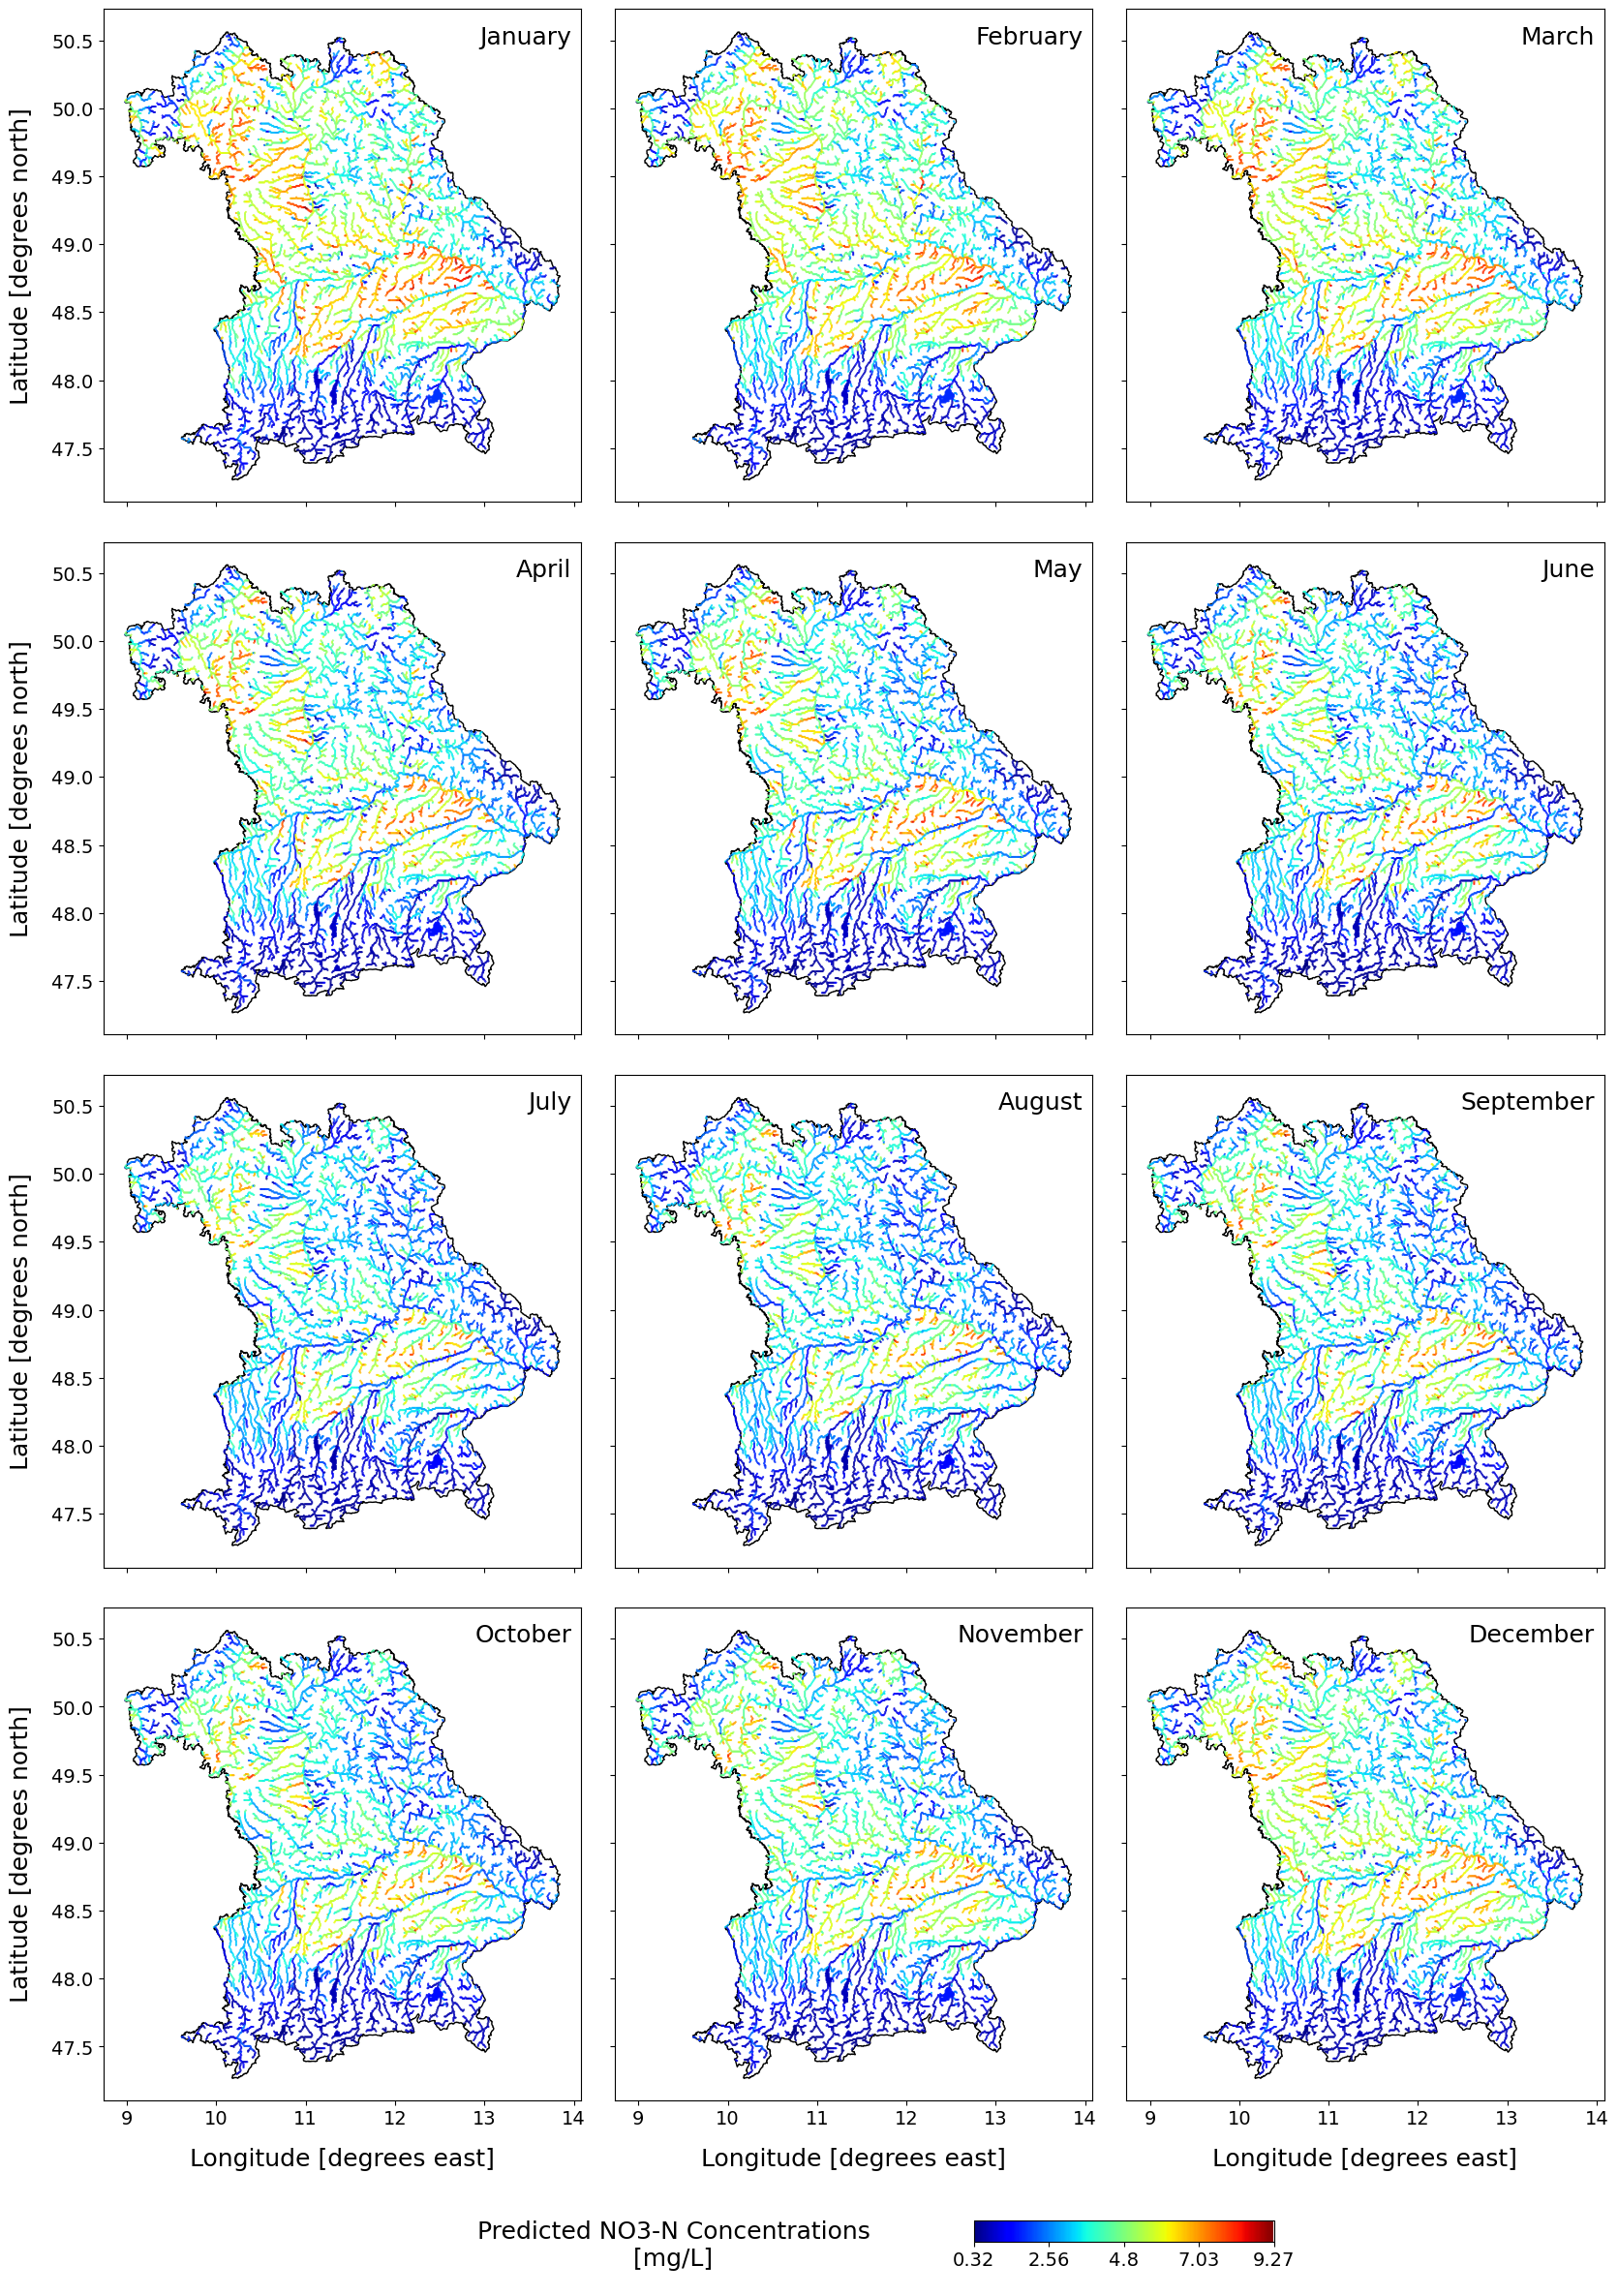

In [45]:
# plot the predicted concentrations

df_to_save = df_to_save.to_crs('EPSG:4326')
pred_all = df_to_save["NO3-N mg/l"]

row_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4}  # storing row indices for subplot in a dictionary
col_dict = {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2}  # storing column indices for subplot in a dictionary
label_dict = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July', 7: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December'}  # storing labels for subplot in a dictionary


norm = plt.Normalize(vmin=pred_all.min(), vmax=pred_all.max())
fig = plt.figure(figsize=(20, 30))
grid = plt.GridSpec(5, 3, wspace = 0.07,hspace = 0.01, height_ratios=[10,10,10,10,2])



for i in range(13):
    
    if i < 12:    
        df_month = df_to_save.loc[df_to_save["month"]== i+1, :]
        ax = fig.add_subplot(grid[row_dict[i], col_dict[i]])
        bavaria_polygon.plot(ax=ax, color='white', edgecolor='black')
        sc = ax.scatter(df_month.iloc[:,2].x, df_month.iloc[:,2].y, c=norm(df_month.iloc[:,1]), cmap='jet', s=0.2)
        
        ax.text(0.98, 0.93, label_dict[i], transform = ax.transAxes, size = 18,ha='right')
        
        # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
        if i in range(9,12):
            
            ax.set_xlabel('Longitude [degrees east]', fontsize = 18, labelpad = 14)

        
        # only add y label for the first column of subplot    
        if i in range(0,10,3):
            
            ax.set_ylabel('Latitude [degrees north]', fontsize = 18, labelpad = 14)

            
        if i not in range(9,12):
            ax.set_xticklabels([])
        
        
        if i not in range(0,10,3): 
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    
    else:
        # plot the legend in the last row of subplot and combine all the columns
        cbar_ax = fig.add_subplot(grid[row_dict[i], :])
        
# manually adjust the positions of the subplots and the color bar
for ax in fig.axes[:-1]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])      

# insert the colorbar as an axes in the last row of subplot grid. this row was reserved for legend and has no data. 
cax = cbar_ax.inset_axes([0.58, 0.42,0.2, 0.2], transform=cbar_ax.transAxes) # [left, bottom, width, height] 
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), cax=cax, orientation='horizontal')
min_cbar = round((pred_all.min()), 2)
max_cbar = round((pred_all.max()),2)
ticks = np.linspace(min_cbar,max_cbar , 5)
cbar.set_ticks(ticks) # the colorbar represents the normalized data by default so add ticks manually
cbar.set_ticklabels(np.around(np.linspace(min_cbar,max_cbar , 5), decimals = 2), fontsize=14 )
cbar_ax.text(0.38, 0.2, "Predicted NO3-N Concentrations\n [mg/L] ", fontsize=18, ha="center", transform=cbar_ax.transAxes)

# remove boundaries of the last row of subplot grid
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)


plt.savefig('final_predictions_new_500dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=500)
    

In [46]:
y_test_og = inv_boxcox(y_test, lambda_boxcox)
y_pred_opt_merged_og = inv_boxcox(y_pred_opt_merged, lambda_boxcox)

In [47]:
print(residuals)

NameError: name 'residuals' is not defined

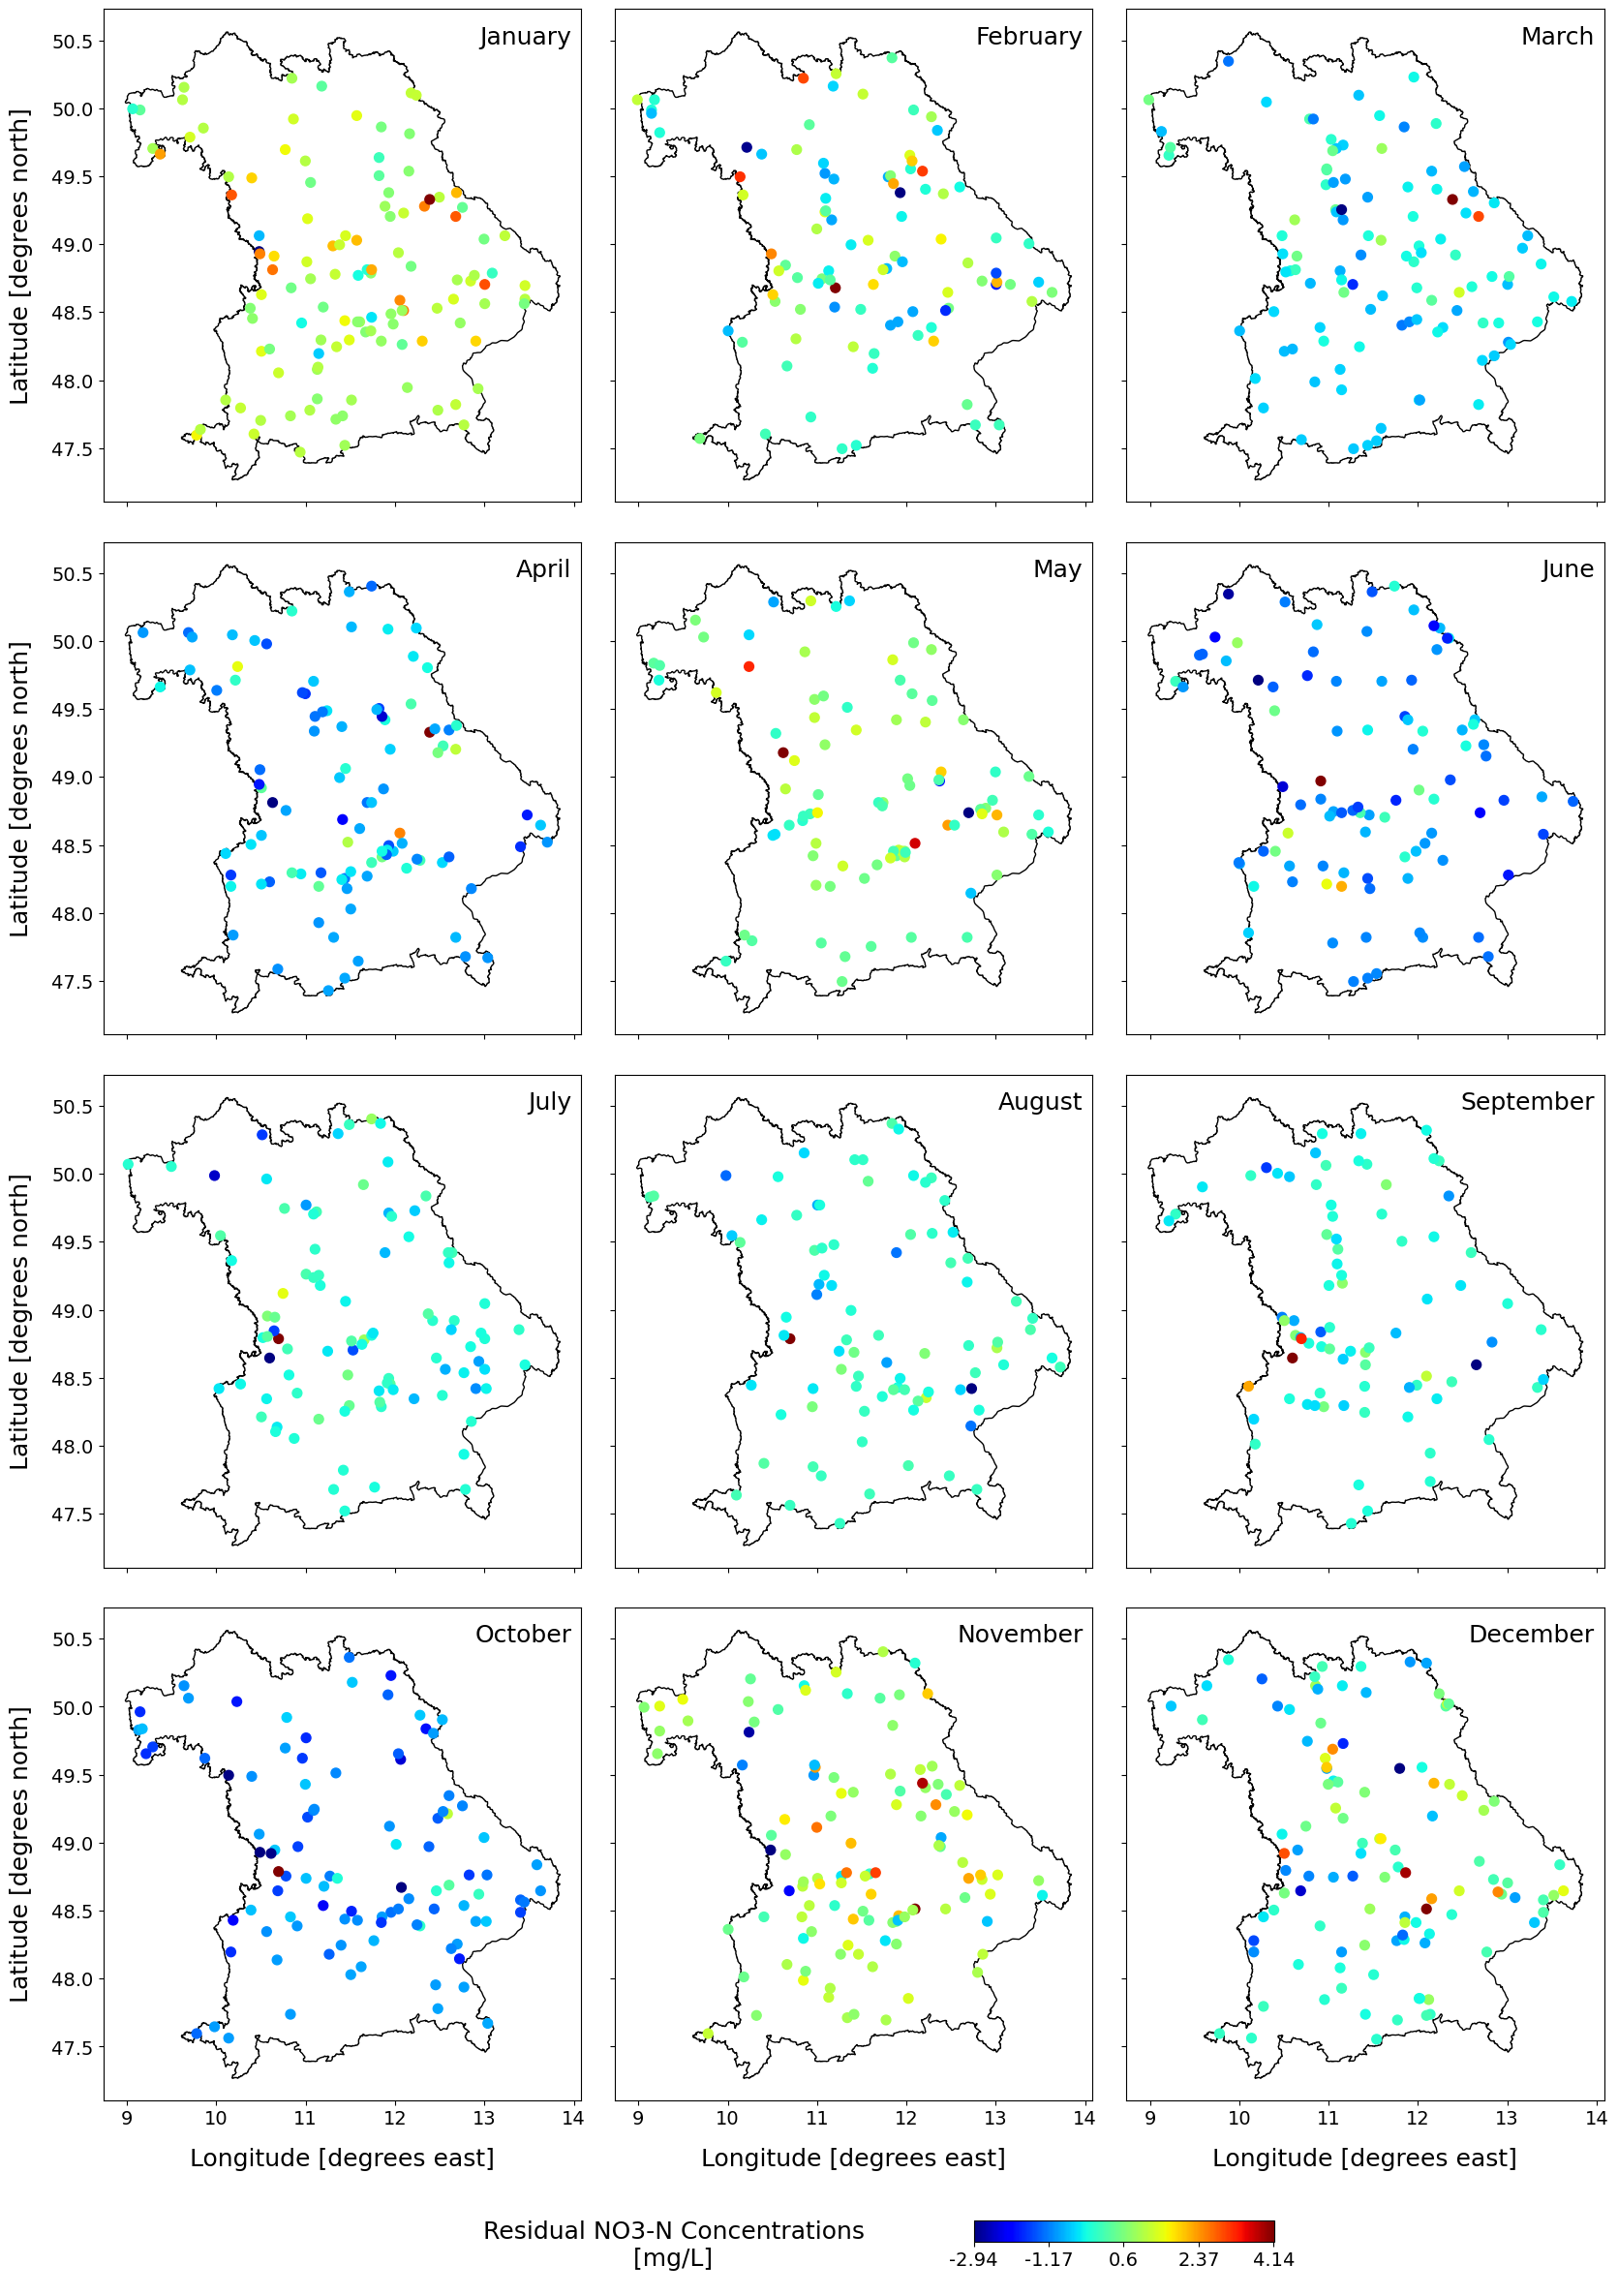

In [48]:
# Residual plot 

residuals = y_test_og - y_pred_opt_merged_og
row_indices = X_test.index.tolist()
X_test_copy = X_test.copy()
# Get the months corresponding to the data in the validation set
X_test_copy['month'] = merged_dfs_scaled.loc[row_indices, "month"]
X_test_copy['lon'] = merged_dfs_scaled.loc[row_indices, "lon"]
X_test_copy['lat'] = merged_dfs_scaled.loc[row_indices, "lat"]
X_test_copy['residuals'] = residuals

#df_to_save = df_to_save.to_crs('EPSG:4326')
pred_all = X_test_copy["residuals"]

row_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4}  # storing row indices for subplot in a dictionary
col_dict = {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2}  # storing column indices for subplot in a dictionary
label_dict = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July', 7: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December'}  # storing labels for subplot in a dictionary


norm = plt.Normalize(vmin=pred_all.min(), vmax=pred_all.max())
fig = plt.figure(figsize=(20, 30))
grid = plt.GridSpec(5, 3, wspace = 0.07,hspace = 0.01, height_ratios=[10,10,10,10,2])



for i in range(13):
    
    if i < 12:    
        #df_month = df_to_save.loc[df_to_save["month"]== i+1, :]
        df_month = X_test_copy.loc[X_test_copy["month"]== i+1, :]
        ax = fig.add_subplot(grid[row_dict[i], col_dict[i]])
        bavaria_polygon.plot(ax=ax, color='white', edgecolor='black')
        sc = ax.scatter(df_month["lon"], df_month["lat"], c=norm(df_month["residuals"]), cmap='jet', s=50)
        
        ax.text(0.98, 0.93, label_dict[i], transform = ax.transAxes, size = 18,ha='right')
        
        # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
        if i in range(9,12):
            
            ax.set_xlabel('Longitude [degrees east]', fontsize = 18, labelpad = 14)

        
        # only add y label for the first column of subplot    
        if i in range(0,10,3):
            
            ax.set_ylabel('Latitude [degrees north]', fontsize = 18, labelpad = 14)

            
        if i not in range(9,12):
            ax.set_xticklabels([])
        
        
        if i not in range(0,10,3): 
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    
    else:
        # plot the legend in the last row of subplot and combine all the columns
        cbar_ax = fig.add_subplot(grid[row_dict[i], :])
        
# manually adjust the positions of the subplots and the color bar
for ax in fig.axes[:-1]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])      

# insert the colorbar as an axes in the last row of subplot grid. this row was reserved for legend and has no data. 
cax = cbar_ax.inset_axes([0.58, 0.42,0.2, 0.2], transform=cbar_ax.transAxes) # [left, bottom, width, height] 
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), cax=cax, orientation='horizontal')
min_cbar = round((pred_all.min()), 2)
max_cbar = round((pred_all.max()),2)
ticks = np.linspace(min_cbar,max_cbar , 5)
cbar.set_ticks(ticks) # the colorbar represents the normalized data by default so add ticks manually
cbar.set_ticklabels(np.around(np.linspace(min_cbar,max_cbar , 5), decimals = 2), fontsize=14 )
cbar_ax.text(0.38, 0.2, "Residual NO3-N Concentrations\n [mg/L] ", fontsize=18, ha="center", transform=cbar_ax.transAxes)

# remove boundaries of the last row of subplot grid
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)


plt.savefig('residuals_CRS_new_500dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=500)    